## <div style="text-align: center"><font color='#dc2624' face='微软雅黑'>案例分析 - 构建债券收益率曲线</font></div>

## <font color='#dc2624' face='微软雅黑'>目录</font><a name='toc'></a>
### 1. [**<font color='#dc2624' face='微软雅黑'>基本概念</font>**](#1)
1. [<font color='#2b4750' face='微软雅黑'>收益率曲线 101</font>](#1.1)
2. [<font color='#2b4750' face='微软雅黑'>债券 101</font>](#1.2)

### 2. [**<font color='#dc2624' face='微软雅黑'>Nelson Siegel 模型</font>**](#2)
1. [<font color='#2b4750' face='微软雅黑'>瞬时远期利率</font>](#2.1)
2. [<font color='#2b4750' face='微软雅黑'>即期利率</font>](#2.2)
3. [<font color='#2b4750' face='微软雅黑'>Svensson 模型</font>](#2.3)

### 3. [**<font color='#dc2624' face='微软雅黑'>Nelson Siegel 实现</font>**](#3)
1. [<font color='#2b4750' face='微软雅黑'>数据处理</font>](#3.1)
2. [<font color='#2b4750' face='微软雅黑'>模型优化</font>](#3.2)
3. [<font color='#2b4750' face='微软雅黑'>结果分析</font>](#3.3)
---

## <font color='#dc2624' face='微软雅黑'>目标</font>
在固定收益 (fixed-income) 世界中，收益率曲线毫无疑问是最重要的概念。它表示给定发行人和给定时间点，投资**<font color='red'>收益率</font>** (yield) 和**<font color='red'>期限</font>** (tenor) 之间的关系。市场中没有单一的收益率曲线，在不同的**时间点** (time)，对不同的**货币** (currency)，对不同的**发行人** (issuer) 和不同的**信贷水平** (rating) 有一系列不同的收益率曲线。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
from datedelta import datedelta

import scipy.optimize as spo

In [2]:
np.random.seed(1031)
mpl.rcParams['font.sans-serif']=['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus']=False

In [3]:
import cufflinks as cf
cf.go_offline()

color =  [ 'rgb(220,38,36)', 'rgb(43,71,80)', 'rgb(69,160,162)', 
           'rgb(232,122,89)', 'rgb(125,202,169)', 'rgb(100,158,125)', 
           'rgb(220,128,24)', 'rgb(200,159,145)', 'rgb(108,109,108)', 
           'rgb(79,98,104)', 'rgb(199,204,207)' ]

# <font color='#dc2624' face='微软雅黑'>1. 基本概念</font><a name='1'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)
### <font color='#2b4750' face='微软雅黑'>1.1 收益率曲线 101</font><a name='1.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

收益率曲线是核心概念，我们来看看 **2020 年 10 月 16 日** 的美国国债曲线长得是什么样的。首先从 csv 文件中读取。

In [4]:
UST = pd.read_csv( 'US Treasury Curve (10-16-2020).csv', index_col=0 )
UST

,Yield (%)
Peirod,
1M,0.09
3M,0.11
1Y,0.12
2Y,0.14
3Y,0.18
5Y,0.32
7Y,0.53
10Y,0.76
20Y,1.30


In [5]:
UST.iplot( kind='scatter', mode='lines+markers', size=10, 
           title='2020 年 10 月 16 日美国国债收益率曲线', xTitle='期限', yTitle='收益率 (%)', 
           color=color, theme='solar' )

解释上图

- 水平轴描述了该日期每种已发行美国国债的<font color='red'>期限</font> (maturity)。
- 垂直轴是观察到的国债对应的<font color='red'>收益率</font> (yield %)。

不难发现，较短期限的债券比期限较长的美国国债的收益率低，一般来说，收益率曲线都是**向上倾斜**的 (upward-sloping)。

用符号 <font color='blue'>$T$</font> 和 <font color='blue'>$y$</font> 来表示期限和收益率，那么它们之间的关系可抽象的写成：

<br>
<font color='blue'>
\begin{equation}
y = f(T)
\end{equation}
</font>

其中 <font color='blue'>$f(\cdot)$</font> 就是想要找到收益率和期限之间的对应关系。

当我们谈论收益曲线模型时，有两种情况：

1. 在给定时间点的收益率曲线的形式 (at a point of time)
2. 收益率曲线随时间变化的动态 (through time)

<img src="yield curve modeling.PNG" style="width:700px;height:350px;">

### <font color='#2b4750' face='微软雅黑'>1.2 债券 101</font><a name='1.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

债券分固定利率和浮动利率，用于构建收益率曲线的绝大部分都是固定债，每期支付利息 (coupon)，到期归还本金。支付频率可以是每年、每半年、每季度和每月。固定债券的支付结构图如下：

<img src="fixed rate bond no AI.PNG" style="width:500px;height:250px;">

计算债券的现值公式：

<br>
<font color='blue'>
\begin{equation}
V(t)=\sum_{n=1}^{N} \frac{\frac{c}{f}}{(1+\frac{y}{f})^{f\cdot n}}+\frac{1}{(1+\frac{y}{f})^{f\cdot N}}
\end{equation}
</font>

一般估值日不会刚好落在债券的付息日，如下图所示：

<img src="fixed rate bond.PNG" style="width:800px;height:280px;">

计算债券的现值公式：

<br>
<font color='blue'>
\begin{equation}
V(t)=\sum_{n=1}^{N} \frac{\frac{c}{f}}{(1+\frac{y}{f})^{f\cdot (T_n - t)}}+\frac{1}{(1+\frac{y}{f})^{f\cdot (T_N - t)}}
\end{equation}
</font>

上面计算的债券价值称为**全价** (dirty price)，但其实市场上债券报价的都是**净价** (clean price)，两者之间相差一个**累计利息** (accrued interest)，如上图所示：

<br>
<font color='blue'>
\begin{equation}
V_{\text{CP}}(t)=V_{\text{DP}}(t) - \text{AI} = \sum_{n=1}^{N} \frac{\frac{c}{f}}{(1+\frac{y}{f})^{f\cdot (T_n - t)}}+\frac{1}{(1+\frac{y}{f})^{f\cdot (T_N - t)}} - \frac{T_1 - t}{T_1 - T_0}\times\frac{c}{f}
\end{equation}
</font>

# <font color='#dc2624' face='微软雅黑'>2. Nelson-Siegel 模型</font><a name='2'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)

Nelson-Siegel (NS) 模型最早由 Nelson 和 Siegel 于 1987 年提出，该模型适用于利率期限结构分析。NS 模型中有四个参数，每个都有自身的经济含义，而且不同参数值能描述不同情境下的利率曲线的变动情况。

### <font color='#2b4750' face='微软雅黑'>2.1 瞬时远期利率</font><a name='2.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

首先 NS 模型制定了瞬时远期利率（instantaneous forward rates）的形式：

<br>
<font color='blue'>
\begin{equation}
f(T-t)=f(t, T)=\beta_{0}+\beta_{1} e^{-\frac{\tau}{\lambda}}+\beta_{2} \frac{\tau}{\lambda} e^{-\frac{\tau}{\lambda}}
\end{equation}
</font>

该模型有四个参数 $\beta_0$, $\beta_1$, $\beta_2$, $\lambda$，其中 $\tau=T-t$ 是到期年限，$\lambda>0$。

瞬时远期利率 $f(t,T)$ 里面有三项：

- 第一项 $\beta_0$ 是当 $\tau$ 趋近无穷大时的远期利率，因此 <font color='blue'>$f(\infty) = \beta_0$</font>。
- 第二项是个 $\tau$ 的单调函数，当 $\beta_1>0$ 时递减，当 $\beta_1<0$ 时递增。
- 第三项是个 $\tau$ 的非单调函数，可以产生驼峰 (hump)。

当 $\tau$ 趋近零时，第二项趋近于 $\beta_1$，第三项趋近于 $0$，因此 <font color='blue'>$f(0)=\beta_0+\beta_1$</font>。

用下图来分解 NS 模型中的三项：

<img src="NS visualization.PNG" style="width:800px;height:400px;">

注意 $\beta_1$ 是负数，因此第二项是增函数，注意蓝线缓缓向上。$\beta_2$ 也是负数，因此第三项是先减后增，有个谷底，而不是峰顶。

### <font color='#2b4750' face='微软雅黑'>2.2 即期利率</font><a name='2.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)
    
根据即期利率和瞬时远期利率之间的关系，我们求积分得到

<br>
<font color='blue'>
\begin{equation}
\begin{aligned}
R(T-t)=R(t, T) &=\frac{1}{T-t} \int_{t}^{T} f(t,u) du \\
&=\frac{1}{T-t} \int_{t}^{T}\left(\beta_{0}+\beta_{1} e^{-\frac{u-t}{\lambda}}+\beta_{2} \frac{u-t}{\lambda} e^{-\frac{u-t}{\lambda}}\right) du \\
&=\beta_{0}+\beta_{1}\left(\frac{1-e^{-\frac{T-t}{\lambda}}}{\frac{T-t}{\lambda}}\right)+\beta_{2}\left(\frac{1-e^{-\frac{T-t}{\lambda}}}{\frac{T-t}{\lambda}}-e^{-\frac{T-t}{\lambda}}\right) \\
&=\beta_{0}+\beta_{1}\left(\frac{1-e^{-\frac{\tau}{\lambda}}}{\frac{\tau}{\lambda}}\right)+\beta_{2}\left(\frac{1-e^{-\frac{\tau}{\lambda}}}{\frac{\tau}{\lambda}}-e^{-\frac{\tau}{\lambda}}\right)
\end{aligned}
\end{equation}
</font>

即期利率 $R(T-t)$ 里面也有三项。

- 第一项 $\beta_0$ 是当 $\tau$ 趋近无穷大时的即期利率，因此 <font color='blue'>$R(\infty) = \beta_0$</font>。
- 第二项是个 $\tau$ 的单调函数，当 $\beta_1>0$ 时递减，当 $\beta_1<0$ 时递增。
- 第三项是个 $\tau$ 的非单调函数，可以产生驼峰 (hump)。

当 $\tau$ 趋近零时，第二项趋近于 $\beta_1$，第三项趋近于 $0$，因此 <font color='blue'>$R(0)=\beta_0+\beta_1$</font>。

将上面等式写成因子形式

<br>
<font color='blue'>
\begin{equation}
R(T-t)=\beta_{0} \cdot 1+\beta_{1} \cdot\left(\frac{1-e^{-\frac{\tau}{\lambda}}}{\frac{\tau}{\lambda}}\right)+\beta_{2} \cdot\left(\frac{1-e^{-\frac{\tau}{\lambda}}}{\frac{\tau}{\lambda}}-e^{-\frac{\tau}{\lambda}}\right)
\end{equation}
</font>

上式包含四个重点：

- <font color='red'>$\beta_0$</font> 的因子载荷是**<font color='red'>常数</font>**，对于对所有期限利率的影响是相同的，因此 $\beta_0$ 可控制**<font color='red'>利率水平</font>** (level)，它的变动会使得收益率曲线发生水平上下移动。


- <font color='blue'>$\beta_1$</font> 的因子载荷是**<font color='blue'>单调递减</font>**，从 1 很快的衰减到 0，这表明 $\beta_1$ 对短端利率的影响较大，因此 $\beta_1$ 可控制曲线**<font color='blue'>斜率</font>** (slope)，影响着利率曲线的斜率程度。


- <font color='green'>$\beta_2$</font> 的因子载荷**<font color='green'>先增后减</font>**，从 0 增到 1 再减到 0，这表明 $\beta_2$ 对利率曲线的短端和长端影响较弱，对中端的影响较大，因此 $\beta_2$ 控制曲线**<font color='green'>曲率</font>** (curvature)。


- $\lambda$ 是 $\beta_1$ 和 $\beta_2$ 的因子载荷的衰减速度，该值越小衰减越快。

### <font color='#2b4750' face='微软雅黑'>2.3 Svensson 模型</font><a name='2.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

NS 模型可以模拟利率曲线的最基本的三种形式：**平移**、**斜率**和**曲率**。在 NS 基础上，Svensson 在 1994 年做了改进，为了能多模拟一个 驼峰 (hump) 形状而增加了两个参数。该模型下的瞬时远期利率的形式为:

<br>
<font color='blue'>
\begin{equation}
f(T-t)=f(t, T)=\beta_{0}+\beta_{1} e^{-\frac{\tau}{\lambda_{1}}}+\beta_{2} \frac{\tau}{\lambda_{1}} e^{-\frac{\tau}{\lambda_{1}}}+\beta_{3} \frac{\tau}{\lambda_{2}} e^{-\frac{\tau}{\lambda_{2}}}
\end{equation}
</font>
    
该模型有六个参数 $\beta_0$, $\beta_1$, $\beta_2$, $\beta_3$, $\lambda_1$, $\lambda_2$，其中 $\tau=T-t$ 是到期年限，$\lambda_1 >0$, $\lambda_2>0$。

同样求积分我们可得到即期利率:

<br>
<font color='blue'>
\begin{equation}
R(T-t)=R(t, T)=\beta_{0}+\beta_{1}\left(\frac{1-e^{-\frac{\tau}{\lambda_{1}}}}{\frac{\tau}{\lambda_{1}}}\right)+\beta_{2}\left(\frac{1-e^{-\frac{\tau}{\lambda_{1}}}}{\frac{\tau}{\lambda_{1}}}-e^{-\frac{\tau}{\lambda_{1}}}\right)+\beta_{3}\left(\frac{1-e^{-\frac{\tau}{\lambda_{2}}}}{\frac{\tau}{\lambda_{2}}}-e^{-\frac{\tau}{\lambda_{2}}}\right)
\end{equation}
</font>

Svensson 模型可以处理两个驼峰，模型表达能力更强了，但是对于简单类型的利率曲线也更容易过拟合。根据我在实际操作中没有发现它显著强于 NS 模型，而且在拟合 10 年的历史数据的债券收益率曲线时，Svensson 模型更容易发生参数跳跃的情形，这不是我们希望看到的结果。因此我还是偏向于用 NS 模型。

# <font color='#dc2624' face='微软雅黑'>3. Nelson-Siegel 实现</font><a name='3'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)

### <font color='#2b4750' face='微软雅黑'>3.1 数据处理</font><a name='3.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

在某个行业某个评级下都有一系列交易的债券，根据其市场价格或收益率可以拟合出来一条收益率曲线。在某个观测日 **2018 年 1 月 24 日**，拿欧元区 AA 金融行业 (EUR Financial AA) 举例，读取数据，将债券发行日和到期日用 pd.to_datetime() 转成专门的日期格式。

In [6]:
eval_date = datetime(2018, 1, 24)
eval_date

datetime.datetime(2018, 1, 24, 0, 0)

在用 NS 模型对收益率曲线建模时不需要知道每笔债券具体本金数额大小，因此为了简便，设定债券本金为 100。

In [7]:
notional = 100

In [8]:
BOND = pd.read_csv( 'Bond data.csv', index_col=0, dayfirst=True )
BOND['Issue Date'] = pd.to_datetime(BOND['Issue Date'], dayfirst=True)
BOND['Maturity Date'] = pd.to_datetime(BOND['Maturity Date'], dayfirst=True)
BOND.head().append(BOND.tail())

,Issue Date,Maturity Date,Yield,Coupon Rate,Coupon Frequency,Clean Price
ISIN,,,,,,
XS0881511868,2017-02-04,2019-02-04,-0.002626,0.01625,Annual,101.931396
XS1045283766,2017-03-18,2019-03-18,-0.002167,0.01500,Annual,101.968803
FR0000583155,2017-06-01,2019-06-01,0.003497,0.07750,Annual,109.878998
XS1077588017,2017-06-17,2019-06-17,-0.001604,0.01125,Annual,101.805000
XS0728763938,2017-07-11,2019-07-11,-0.001915,0.04000,Annual,106.104401
XS1689535000,2017-09-27,2027-09-27,0.010684,0.01125,Annual,100.526604
DE000A1HG1K6,2017-03-13,2028-03-13,0.010146,0.03000,Annual,119.108803
XS1411401083,2017-05-12,2028-05-12,0.010534,0.01250,Annual,102.013000
XS1476654584,2017-08-15,2028-08-15,0.011153,0.00750,Annual,96.569000


In [9]:
BOND.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, XS0881511868 to XS1001594065
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Issue Date        85 non-null     datetime64[ns]
 1   Maturity Date     85 non-null     datetime64[ns]
 2   Yield             85 non-null     float64       
 3   Coupon Rate       85 non-null     float64       
 4   Coupon Frequency  85 non-null     object        
 5   Clean Price       85 non-null     float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 4.6+ KB


对于零息债券 (zero-coupon bond)，没有 `Coupon Frequency` 字段下为空，用 -1 填充。

In [10]:
idx_NaN = BOND['Coupon Frequency'].isna()
BOND.loc[idx_NaN, 'Coupon Frequency'] = BOND.loc[idx_NaN, 'Coupon Frequency'].fillna(-1)

生成每个债券的付息日需要下面两个函数：

    get_freq 的参数是字符串格式比如 Annual, Semiannual, Quarter 等，转换成数值形式，返回一个元组，第一个元素是“每年的期数”，第二个元素是“每期的月数”
    
    date_generator 的参数包括债券的发行日、到期日、息票率、付息频率和估值日，返回债券的有效付息日

In [11]:
def get_freq(f):
    if isinstance(f, str): 
        n_of_period_per_year = {'a':1, 's':2, 'q':4, 'm':12}
        n_of_month_per_period = {'a':12, 's':6, 'q':3, 'm':1}
        output = ( n_of_period_per_year[f[0].lower()], n_of_month_per_period[f[0].lower()] )
    else:
        output = (int(f), int(12/f))
    return output

def date_generator( issue_date, maturity_date, coupon, freq, eval_date ):
    # Generate all dates between issue date and maturity date    
    bond_dates = []
    
    for date_s, date_e, c, f in zip(issue_date, maturity_date, coupon, freq):
        if f == -1: # zero-coupon bond
            date_array = np.array([date_s, date_e])
        else: # coupon-bearing bond
            (n_of_prd, n_of_mth) = get_freq(f)
            n_of_yr = np.ceil((date_e-date_s).days/365.25)
            date_array = np.array( [date_s+datedelta(months=n_of_mth*i) for i in np.arange(n_of_prd*n_of_yr+1)])
        cutoff = date_array < eval_date
        how_many = np.sum(cutoff)
        if how_many == 0: # the bond is not effective yet
            bond_dates.append( date_array )
        else: # the bond is effective, include the first bond date less than evaluation date 
            bond_dates.append( date_array[how_many-1:] )
    
    return bond_dates

In [12]:
coupon = BOND['Coupon Rate']
freq = BOND['Coupon Frequency']
date_issue = BOND['Issue Date']
date_mature = BOND['Maturity Date']

bond_dates = date_generator( date_issue, date_mature, coupon, freq, eval_date )
bond_dates

[array([Timestamp('2017-02-04 00:00:00'), Timestamp('2018-02-04 00:00:00'),
        Timestamp('2019-02-04 00:00:00')], dtype=object),
 array([Timestamp('2017-03-18 00:00:00'), Timestamp('2018-03-18 00:00:00'),
        Timestamp('2019-03-18 00:00:00')], dtype=object),
 array([Timestamp('2017-06-01 00:00:00'), Timestamp('2018-06-01 00:00:00'),
        Timestamp('2019-06-01 00:00:00')], dtype=object),
 array([Timestamp('2017-06-17 00:00:00'), Timestamp('2018-06-17 00:00:00'),
        Timestamp('2019-06-17 00:00:00')], dtype=object),
 array([Timestamp('2017-07-11 00:00:00'), Timestamp('2018-07-11 00:00:00'),
        Timestamp('2019-07-11 00:00:00')], dtype=object),
 array([Timestamp('2017-07-22 00:00:00'), Timestamp('2018-07-22 00:00:00'),
        Timestamp('2019-07-22 00:00:00')], dtype=object),
 array([Timestamp('2017-09-30 00:00:00'), Timestamp('2018-09-30 00:00:00'),
        Timestamp('2019-09-30 00:00:00')], dtype=object),
 array([Timestamp('2018-01-14 00:00:00'), Timestamp('2019-01-1

In [13]:
# tenor from payment dates to evaluation dates: act/365
T = [ 
        np.array(list(map(lambda x:x.days/365, diff))) 
        for diff in [d[1:]-eval_date for d in bond_dates]
    ]
T

[array([0.03013699, 1.03013699]),
 array([0.14520548, 1.14520548]),
 array([0.35068493, 1.35068493]),
 array([0.39452055, 1.39452055]),
 array([0.46027397, 1.46027397]),
 array([0.49041096, 1.49041096]),
 array([0.68219178, 1.68219178]),
 array([0.97260274, 1.97260274]),
 array([0.99178082, 1.99178082]),
 array([0.97808219, 1.97808219]),
 array([0.08767123, 1.08767123, 2.08767123]),
 array([0.42739726, 1.42739726, 2.43013699, 3.43013699]),
 array([0.42739726, 1.42739726, 2.43013699, 3.43013699]),
 array([0.46575342, 1.46575342, 2.46849315, 3.46849315]),
 array([0.5890411 , 1.5890411 , 2.59178082, 3.59178082]),
 array([0.8       , 1.8       , 2.80273973, 3.80273973]),
 array([0.85753425, 1.85753425, 2.86027397, 3.86027397]),
 array([0.96712329, 1.96712329, 2.96986301]),
 array([0.97534247, 1.97534247, 2.97808219]),
 array([0.94520548, 1.94520548, 2.94794521]),
 array([0.08493151, 1.08493151, 2.08493151, 3.08767123]),
 array([0.06575342, 1.06575342, 2.06575342, 3.06849315]),
 array([0.06

In [14]:
# accrued interest
AI = [ 
        (eval_date-d[0]).days/360 * c * notional
        for d, c in zip(bond_dates, coupon)
     ]
AI

[1.5979166666666667,
 1.3,
 5.102083333333334,
 0.690625,
 2.188888888888889,
 2.454166666666667,
 0.7652777777777778,
 0.11458333333333333,
 0.03670833333333333,
 0.04166666666666667,
 4.046875,
 2.3222222222222224,
 2.249652777777778,
 2.1666666666666665,
 0.9375,
 0.40555555555555556,
 0.09027777777777778,
 0.1375,
 0.1,
 0.034722222222222224,
 4.059027777777778,
 1.8944444444444444,
 0.83125,
 1.8166666666666669,
 0.5590277777777778,
 1.38125,
 2.8072916666666665,
 0.5274305555555555,
 0.4479166666666667,
 1.1666666666666665,
 0.9072916666666666,
 0.036458333333333336,
 0.14444444444444443,
 0.07083333333333333,
 0.009722222222222222,
 0.009722222222222222,
 0.004861111111111111,
 3.344444444444445,
 0.68125,
 0.22916666666666666,
 1.09375,
 0.8138888888888888,
 3.0611111111111113,
 0.6583333333333333,
 1.832638888888889,
 0.17333333333333334,
 0.27361111111111114,
 1.2909722222222222,
 1.1229166666666666,
 0.11666666666666668,
 0.1351388888888889,
 0.7322916666666667,
 0.109375000

In [15]:
#Freq = [ get_freq(f)[0] for f in BOND['Coupon Frequency'] ]
year_frac = [
                np.ones(len(d)-1)*(1/get_freq(f)[0]) for d, f in zip(bond_dates, freq)
            ]

cashflows = [ 
                alpha * c * notional + (np.arange(len(alpha))==(len(alpha)-1)) * notional
                for alpha, c in zip(year_frac, coupon)
            ]
cashflows

[array([  1.625, 101.625]),
 array([  1.5, 101.5]),
 array([  7.75, 107.75]),
 array([  1.125, 101.125]),
 array([  4., 104.]),
 array([  4.75, 104.75]),
 array([  2.375, 102.375]),
 array([  4.125, 104.125]),
 array([  4.405, 104.405]),
 array([  1.875, 101.875]),
 array([  4.375,   4.375, 104.375]),
 array([  4.,   4.,   4., 104.]),
 array([  3.875,   3.875,   3.875, 103.875]),
 array([  4.,   4.,   4., 104.]),
 array([  2.25,   2.25,   2.25, 102.25]),
 array([  2.,   2.,   2., 102.]),
 array([  0.625,   0.625,   0.625, 100.625]),
 array([  4.125,   4.125, 104.125]),
 array([  4.,   4., 104.]),
 array([  0.625,   0.625, 100.625]),
 array([  4.375,   4.375,   4.375, 104.375]),
 array([  2.,   2.,   2., 102.]),
 array([  0.875,   0.875,   0.875, 100.875]),
 array([  2.,   2.,   2., 102.]),
 array([  0.625,   0.625,   0.625, 100.625]),
 array([  1.625,   1.625,   1.625, 101.625]),
 array([  4.375,   4.375,   4.375, 104.375]),
 array([  0.875,   0.875,   0.875, 100.875]),
 array([  1.25,

In [16]:
# year fraction between consecutive payment dates: assuming date count convention act/360
# year_frac = [ 
#                 np.array(list(map(lambda x:x.days/360, diff)))
#                 for diff in [d[1:]-d[:-1] for d in bond_dates]
#             ]
# cashflows = [ 
#                 alpha * c * notional + (np.arange(len(alpha))==(len(alpha)-1)) * notional
#                 for alpha, c in zip(year_frac, coupon)
#             ]
# cashflows

In [17]:
BOND['Accrued Interest'] = AI
BOND['Dirty Price'] = BOND['Accrued Interest'] + BOND['Clean Price']

In [18]:
BOND.head().append(BOND.tail())

,Issue Date,Maturity Date,Yield,Coupon Rate,Coupon Frequency,Clean Price,Accrued Interest,Dirty Price
ISIN,,,,,,,,
XS0881511868,2017-02-04,2019-02-04,-0.002626,0.01625,Annual,101.931396,1.597917,103.529313
XS1045283766,2017-03-18,2019-03-18,-0.002167,0.01500,Annual,101.968803,1.300000,103.268803
FR0000583155,2017-06-01,2019-06-01,0.003497,0.07750,Annual,109.878998,5.102083,114.981081
XS1077588017,2017-06-17,2019-06-17,-0.001604,0.01125,Annual,101.805000,0.690625,102.495625
XS0728763938,2017-07-11,2019-07-11,-0.001915,0.04000,Annual,106.104401,2.188889,108.293290
XS1689535000,2017-09-27,2027-09-27,0.010684,0.01125,Annual,100.526604,0.371875,100.898479
DE000A1HG1K6,2017-03-13,2028-03-13,0.010146,0.03000,Annual,119.108803,2.641667,121.750470
XS1411401083,2017-05-12,2028-05-12,0.010534,0.01250,Annual,102.013000,0.892361,102.905361
XS1476654584,2017-08-15,2028-08-15,0.011153,0.00750,Annual,96.569000,0.337500,96.906500


In [19]:
# modified duration
Freq = [ get_freq(f)[0] for f in BOND['Coupon Frequency'] ]

MD = [
        np.sum((cf/f*t)/(1+y/f)**(f*t) / (DP*(1+y/f)))
        for y, f, cf, t, DP in zip(BOND['Yield'], Freq, cashflows, T, BOND['Dirty Price'])
     ]

BOND['Modified Duration'] = MD

In [20]:
BOND.head().append(BOND.tail())

,Issue Date,Maturity Date,Yield,Coupon Rate,Coupon Frequency,Clean Price,Accrued Interest,Dirty Price,Modified Duration
ISIN,,,,,,,,,
XS0881511868,2017-02-04,2019-02-04,-0.002626,0.01625,Annual,101.931396,1.597917,103.529313,1.017075
XS1045283766,2017-03-18,2019-03-18,-0.002167,0.01500,Annual,101.968803,1.300000,103.268803,1.132955
FR0000583155,2017-06-01,2019-06-01,0.003497,0.07750,Annual,109.878998,5.102083,114.981081,1.278923
XS1077588017,2017-06-17,2019-06-17,-0.001604,0.01125,Annual,101.805000,0.690625,102.495625,1.385511
XS0728763938,2017-07-11,2019-07-11,-0.001915,0.04000,Annual,106.104401,2.188889,108.293290,1.426059
XS1689535000,2017-09-27,2027-09-27,0.010684,0.01125,Annual,100.526604,0.371875,100.898479,9.095653
DE000A1HG1K6,2017-03-13,2028-03-13,0.010146,0.03000,Annual,119.108803,2.641667,121.750470,9.620373
XS1411401083,2017-05-12,2028-05-12,0.010534,0.01250,Annual,102.013000,0.892361,102.905361,10.426957
XS1476654584,2017-08-15,2028-08-15,0.011153,0.00750,Annual,96.569000,0.337500,96.906500,10.890676


### <font color='#2b4750' face='微软雅黑'>3.2 模型优化</font><a name='3.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

编写 NS 模型下的核心函数，包括

    计算瞬时远期利率 NS_instantaneous_forward_rate
    计算即期利率 NS_spot_rate
    计算折现因子 NS_discount
    计算离散远期利率 NS_forward_rate

In [21]:
def NS_instantaneous_forward_rate( beta0, beta1, beta2, lbd, t, T ):
    tau = T - t
    A = tau / lbd
    B = np.exp(-A)
    f = beta0 + beta1*B + beta2*B*A
    f[tau==0] = beta0 + beta1
    return f

def NS_spot_rate( beta0, beta1, beta2, lbd, t, T ):
    tau = T - t
    A = tau / lbd
    B = (1-np.exp(-A)) / A
    R = beta0 + beta1*B + beta2*(B-np.exp(-A))
    R[tau==0] = beta0 + beta1
    return R

def NS_discount(beta0, beta1, beta2, lbd, t, T ):
    R = NS_spot_rate( beta0, beta1, beta2, lbd, t, T )
    DF = np.exp(-R*(T-t))
    return DF

def NS_forward_rate(beta0, beta1, beta2, lbd, t, T1, T2 ):
    DF1 = NS_discount( beta0, beta1, beta2, lbd, t, T1 )
    DF2 = NS_discount( beta0, beta1, beta2, lbd, t, T2 )
    F = 1/(T2-T1) * (DF1/DF2 - 1)
    return F

拟合曲线就是最小化以下的目标函数，它是所有 n 个交易债券的市场价格和模型价格之差的加权平方：

<br>
<font color='blue'>
\begin{equation}
\min _{\beta_{0}, \beta_{1}, \beta_{2}, \lambda} \sum_{i=1}^{n}\left(\omega_{i} \times \frac{\mathrm{D} \mathrm{P}_{i}^{\mathrm{mkt}}-\mathrm{D} \mathrm{P}_{i}^{\mathrm{mdl}}}{\mathrm{DP}_{i}^{\mathrm{mkt}}}\right)^{2}
\end{equation}
</font>
    
其中

- <font color='blue'>$\mathrm{DP}_i^{\mathrm{mkt}}$</font> 是债券的市场**全价** (dirty price)，它等于市场**净价** (clean price) 加上**累计利息** (accrued interest)。

<br>
<font color='blue'>
\begin{equation}
\mathrm{DP}_{i}^{\mathrm{mkt}} = \mathrm{CP}_{i}^{\mathrm{mkt}} + \mathrm{AI}_{i}
\end{equation}
</font>

- <font color='blue'>$\mathrm{DP}_i^{\mathrm{mdl}}$</font> 是债券的模型全价，其表达式为

<br>
<font color='blue'>
\begin{equation}
\mathrm{DP}_{i}^{\mathrm{mdl}}=c \times \sum_{k=1}^{i_{n}} P^{\mathrm{mdl}}\left(t, T_{k}\right)+100 \times P^{\mathrm{mdl}}\left(t, T_{i_{n}}\right)
\end{equation}
</font>

    其中折现因子为

<br>
<font color='blue'>
\begin{equation}
P^{\mathrm{mdl}}(t,T)=e^{-R(t,T)(T-t)}=\exp \left(-\left(\beta_{0} \cdot 1+\beta_{1} \cdot\left(\frac{1-e^{-\frac{\tau}{\lambda}}}{\frac{\tau}{\lambda}}\right)+\beta_{2} \cdot\left(\frac{1-e^{-\frac{\tau}{\lambda}}}{\frac{\tau}{\lambda}}-e^{-\frac{\tau}{\lambda}}\right)\right) \times \tau\right)
\end{equation}
</font>

- <font color='blue'>$\omega_{i}$</font> 是权重，它可以是等权重，也可以是**修正久期** (modified duration) <font color='blue'>$D_{i}^{\mathrm{mod}}$</font>的倒数：

<br>
<font color='blue'>
\begin{equation}
\omega_{i}=\left\{\begin{array}{cc}
\frac{1}{n}, & \text { 等权重 } \\
\frac{1}{D_{i}^{\bmod }} & \text { 不等权重 }
\end{array}\right.
\end{equation}
</font>

而修正久期等于**麦考利久期** (Macaulay duration) <font color='blue'>$D_{i}^{\mathrm{mac}}$</font> 除以 1 加上到期收益率

<br>
<font color='blue'>
\begin{equation}
D_{i}^{\mathrm{mod}}=\frac{D_{i}^{\operatorname{mac}}}{1+\frac{y_{i}}{f_i}}=\frac{1}{1+\frac{y_{i}}{f_i}} \times \frac{\sum_{k=1}^{i_{n}} \frac{\frac{c_i}{f_i}}{\left(1+\frac{y_{i}}{f_i}\right)^{f_i\times(T_{k}-t)}} \times (T_{k}-t)+\frac{100}{\left(1+\frac{y_{i}}{f_i}\right)^{f_i\times(T_{i_{n}}-t)}} \times (T_{i_{n}}-t)}{\mathrm{DP}_{i}^{\mathrm{mkt}}}
\end{equation}
</font>
    
定义目标函数，用修正久期的倒数加权。

In [22]:
def objfun( beta0, beta1, beta2, lbd, T, CF, DP, MD ):
    DF = [ NS_discount(beta0, beta1, beta2, lbd, 0, t) for t in T ]
    NS_DP = np.array( [np.sum(df*cf) for df, cf in zip(DF,CF)] )
    distance = np.sum( ((1/MD)*(1 - NS_DP/DP))**2 )
    return distance

编写核心 NS 模型拟合函数 `NS_fitting`，用 `scipy.optimize.minimize` 解决优化问题整个思路很简单，难点在于如何取好的初始值。一些选取初始值的技巧包括：

- 根据 <font color='blue'>$R(\infty)=\beta_0, R(0)=\beta_0+\beta_1$</font>，我们可以找出交易债券中到期最短和最长的两个收益率 $y_S$ 和 $y_L$

    1. 将 $\beta_0$ 的初始值设置为 $y_L$
    2. 将 $\beta_1$ 的初始值设置为 $y_S-y_L$。


- 假设曲线一开始没有驼峰，将 $\beta_2$ 的初始值设置为 0。


- 对于 $\lambda$ 创建一个初始值网格 (grid)，在上下界 $[\lambda_{\text{min}},\lambda_{\text{max}}]$ 中平均分成 5 段，$\lambda_{\text{min}}$ 通常可定为 1/30，而 $\lambda_{\text{max}}$ 是在最长到期日 $\tau_L$ 下的驼峰对应极值。

In [23]:
def NS_fitting( T, CF, DP, MD, Y ):
    
    beta0_0 = Y[-1]            # yield at longest maturity
    beta1_0 = Y[0] - beta0_0   # yield at shortest maturity
    beta2_0 = 0
    lbd_0 = 1/0.6 
    
    x0 = (beta0_0, beta1_0, beta2_0, lbd_0)
    
    maxT = np.minimum( 0.5*T[-1][-1], 10 )

    lbd_obj = lambda lbd: -1*((1-np.exp(-maxT/lbd))/(maxT/lbd) - np.exp(-maxT/lbd))    
    lbd_ub = spo.minimize( lbd_obj, lbd_0, method='SLSQP', tol=1e-10 )
    lbd_ub = lbd_ub.x[0]
    lbd_lb = 1/30
    
    # objective function
    obj = lambda x: objfun( x[0], x[1], x[2], x[3], T, CF, DP, MD )

    # bounds
    bnds = ((None, None), (None, None), (None, None), (lbd_lb, lbd_ub))
    result = spo.minimize( obj, x0, method='SLSQP', bounds=bnds, tol=1e-10 )
    
    return result

运行结果。

In [24]:
CF = cashflows
Y = BOND['Yield'].values
DP = BOND['Dirty Price'].values
MD = BOND['Modified Duration'].values

result = NS_fitting( T, CF, DP, MD, Y )
result

     fun: 0.0003060013853808605
     jac: array([-1.16885712e-06, -1.36845483e-06,  2.07295670e-07, -1.88971899e-06])
 message: 'Optimization terminated successfully'
    nfev: 149
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([ 0.02977988, -0.03266316, -0.02088604,  4.42592532])

### <font color='#2b4750' face='微软雅黑'>3.3 结果分析</font><a name='3.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

可视化 NS 模型下瞬时远期利率的拆分。

In [25]:
def NS_visualizer( beta0, beta1, beta2, lbd, t, T ):
    
    fig = plt.figure(figsize=(12,6), dpi=150)
    
    tau = T - t
    A = tau / lbd
    idx = (A == 0)
    B = np.exp(-A)
    
    (f1, f2, f3) = (beta0*np.ones(tau.shape), beta1*B, beta2*B*A)
    f = f1 + f2 + f3
    
    ax1 = fig.add_subplot(1,1,1)
    
    ax1.plot( T, f1, '#dc2624', linestyle="--", linewidth=2, label="利率水平" )
    ax1.plot( T, f2, '#2b4750', linestyle="--", linewidth=2, label="利率斜率" )
    ax1.plot( T, f3, '#45a0a2', linestyle="--", linewidth=2, label="利率曲率" )
    ax1.plot( T, f, 'k', linewidth=2, label="瞬时远期利率" )
    
    n = len(T)
    u = 0.003
    (i1, i2, i3, i) = (int(n/5), int(2*n/5), int(3*n/5), int(4*n/5))
    (x1, x2, x3, x) = T[[i1, i2, i3, i]]
    (y1, y2, y3, y) = (f1[i1], f2[i1], f3[i3], f[i])
    
    ax1.annotate( r"第一项：$\beta_0$", 
                  xy=(x1, y1+u),
                  xytext=(x1, y1+4*u),
                  arrowprops=dict( facecolor='#dc2624',
                                   edgecolor='#dc2624', 
                                   headwidth=4,
                                   width=1,
                                   headlength=6 ),
                  horizontalalignment='center',
                  verticalalignment='top' )
    
    ax1.annotate( r"第二项：$\beta_1exp\left({-\frac{\tau}{\lambda}}\right)$",
                  xy=(x2, y2+u),
                  xytext=(x2, y2+4*u),
                  arrowprops=dict( facecolor='#2b4750',
                                   edgecolor='#2b4750',
                                   headwidth=4, 
                                   width=1,
                                   headlength=6 ),
                  horizontalalignment='center', verticalalignment='top' )
    
    ax1.annotate( r"第三项：$\beta_2\frac{\tau}{\lambda}exp\left({-\frac{\tau}{\lambda}}\right)$",
                  xy=(x3, y3+u),
                  xytext=(x3, y3+4*u),
                  arrowprops=dict( facecolor='#45a0a2',
                                   edgecolor='#45a0a2',
                                   headwidth=4, 
                                   width=1,
                                   headlength=6 ),
                  horizontalalignment='center', verticalalignment='top' )
    
    ax1.annotate( r"$\beta_0+\beta_1exp\left({-\frac{\tau}{\lambda}}\right)+\beta_2\frac{\tau}{\lambda}exp\left({-\frac{\tau}{\lambda}}\right)$",
                  xy=(x, y+u),
                  xytext=(x, y+4*u),
                  arrowprops=dict( facecolor='k',
                                   edgecolor='k',
                                   headwidth=4, 
                                   width=1,
                                   headlength=6 ),
                  horizontalalignment='center', verticalalignment='top' )
    
    
    # hump 峰值或谷底
    s = "峰顶" if beta2 > 0 else "谷底"
    u = u if beta2 > 0 else -u
    (x_m, y_m) = (lbd, beta2*np.exp(-1))
    ax1.scatter( x_m, y_m, marker="s", fc="#45a0a2", ec="k", )
    ax1.annotate( s,
                  xy=(x_m, y_m),
                  xytext=(x_m, y_m+u) )
    
    
    ax1.set_ylim(top=f.max()*2)
    ax1.legend(loc=4)
    
    ax1.set_xlabel("年限")
    ax1.set_ylabel("利率 (%)")
    ax1.set_title("Nelson-Siegel 模型的瞬时远期利率的分解")
    
    plt.show()

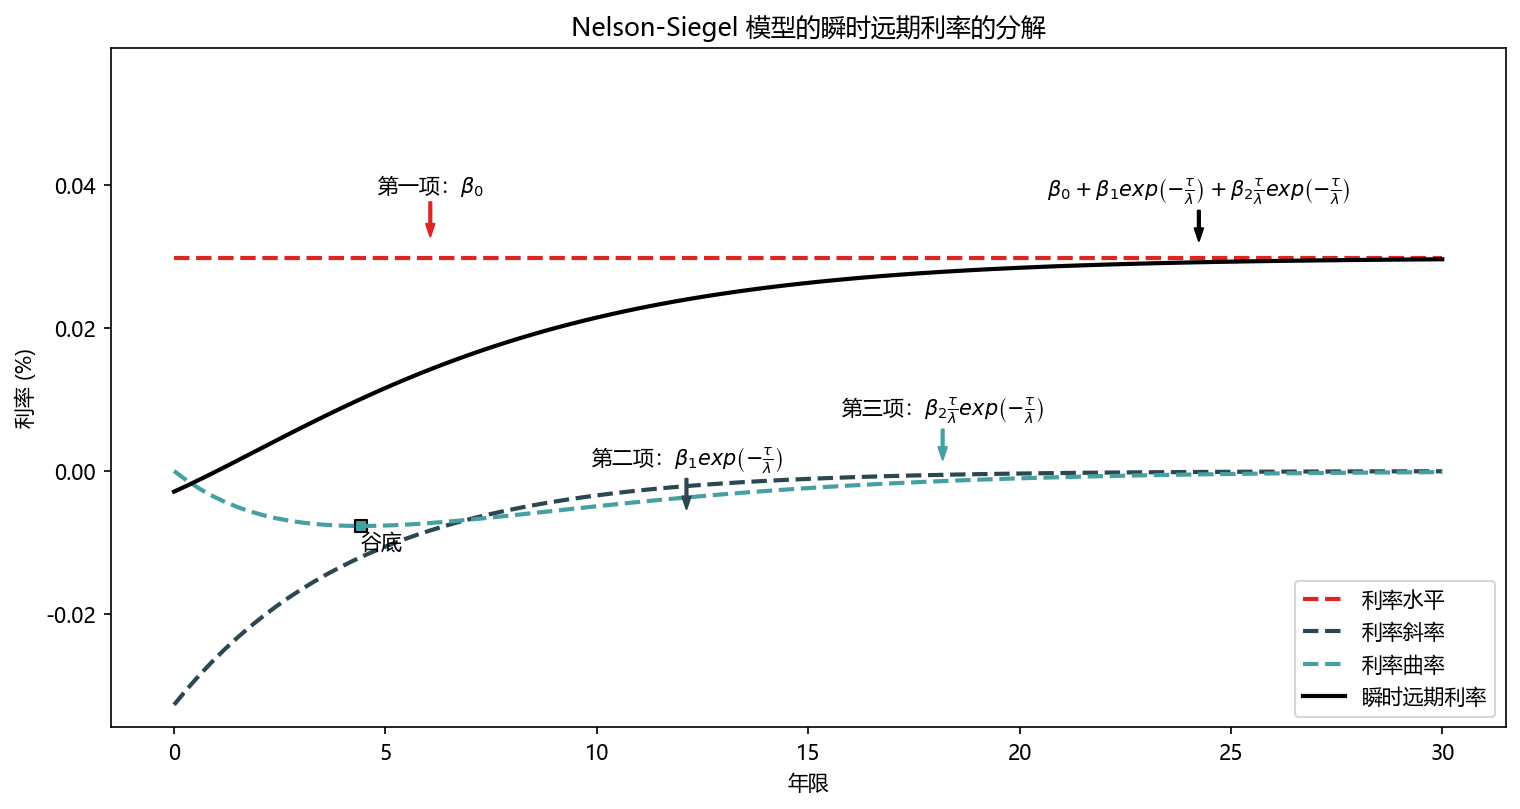

In [26]:
(beta0, beta1, beta2, lbd) = result.x
NS_visualizer( beta0, beta1, beta2, lbd, 0, np.linspace(0,30,100) )

可视化构建出来的**瞬时远期利率**和**即期利率**曲线。

In [27]:
beta0, beta1, beta2, lbd = result.x
maxT = np.ceil((BOND['Maturity Date'].max() - eval_date).days/365)
maturity_vec = np.arange(1/365, maxT, 0.1)
spot_rate = NS_spot_rate( beta0, beta1, beta2, lbd, 0, maturity_vec )
instfwd_rate = NS_instantaneous_forward_rate( beta0, beta1, beta2, lbd, 0, maturity_vec )

In [28]:
df = pd.DataFrame( {'瞬时远期利率':instfwd_rate*100, '即期利率':spot_rate*100}, index=maturity_vec )
df.iplot( kind='scatter', mode='lines+markers', size=3, 
          xTitle='年限', yTitle='利率 (%)', 
          title='欧元区金融业 AA 评级信用债收益率曲线 (Nelson-Siegel 模型)',
          theme='solar' )

In [29]:
def get_YTM( T, f, CF, V ):
    x0 = 0
    #obj = lambda x: np.sum( np.divide(CF, np.power(1+x,T)) ) - V 
    obj = lambda x: np.sum( CF/((1+x/f)**(f*T)) ) - V 
    x = spo.fsolve( obj, x0 )
    return x[0]

In [30]:
def NS_metrics( inst, beta0, beta1, beta2, lbd, eval_date ):
    notional = 100
    
    coupon = BOND['Coupon Rate']
    freq = BOND['Coupon Frequency']
    date_issue = BOND['Issue Date']
    date_mature = BOND['Maturity Date']

    bond_dates = date_generator( date_issue, date_mature, coupon, freq, eval_date )
    
    T = [ 
        np.array(list(map(lambda x:x.days/365, diff))) 
        for diff in [d[1:]-eval_date for d in bond_dates]
    ]
    
    year_frac = [
                np.ones(len(d)-1)*(1/get_freq(f)[0]) for d, f in zip(bond_dates, freq)
                ]
    
    cashflows = [ 
                alpha * c * notional + (np.arange(len(alpha))==(len(alpha)-1)) * notional
                for alpha, c in zip(year_frac, coupon)
            ]
    
    PV = []
    YTM = []
    
    for t, f, CF in zip(T, freq, cashflows):
        DF = NS_discount(beta0, beta1, beta2, lbd, 0, t )
        V = np.sum(DF*CF)
        f = get_freq(f)[0]
        y = get_YTM( t, f, CF, V )
        YTM.append(y)
        PV.append(V)
                
    return np.array(PV), np.array(YTM)

In [31]:
(beta0, beta1, beta2, lbd) = result.x
NS_PV, NS_YTM = NS_metrics( BOND, beta0, beta1, beta2, lbd, eval_date )

In [32]:
df = pd.DataFrame( {'市场价格':BOND['Dirty Price'], '模型价格':NS_PV}, index=BOND.index )
df.iplot( kind='scatter', mode='markers', size=8,
          xTitle='ISIN', yTitle='价格 ($)', 
          title='构建曲线的债券市场价和模型价', theme='solar' )

In [33]:
df = pd.DataFrame( {'市场收益率':BOND['Yield']*100, '模型收益率':NS_YTM*100}, index=BOND.index )
df.iplot( kind='scatter', mode='markers', size=8,
          xTitle='ISIN', yTitle='收益率 (%)', 
          title='构建曲线的债券市场收益率和模型收益率', theme='solar' )

本案例只展示了拟合某行业某评级一天的收益率曲线，在实际操作中，可能需要拟合各行业各评级历史几年的收益率曲线，这时候有三个问题要注意：

1. 去掉交易量不活跃的报价
2. 曲线近端的拟合：引入短期限的 IBOR 
3. 如果随着时间模型参数发现跳跃，加入限制条件，在目标函数加惩罚项